### Solving Biharmonic PDE with Neural Networks

Key features:
- Custom training monitoring callback
- Enhanced early stopping mechanism
- Alternative training methodology

In [1]:
# Libraries
from neurodiffeq import diff
from neurodiffeq.conditions import BaseCondition
from neurodiffeq.callbacks import ActionCallback, SetOptimizer
from neurodiffeq.networks import FCNN
from neurodiffeq.generators import Generator2D
from neurodiffeq.solvers import Solver2D

from torch import cat, exp
from torch.optim import AdamW
from torch.nn import Tanh, MSELoss

from numpy import pi

import matplotlib.pyplot as plt

In [2]:
class ClampedPlateCondition(BaseCondition): # Clapped plate condition
    def __init__(self):
        super().__init__()
        
    def parameterize(self, output_tensor, *input_tensors): # Must be defined
        return output_tensor * (input_tensors[0] ** 2 * (1 - input_tensors[0]) ** 2 * input_tensors[1] ** 2 * (1 - input_tensors[1]) ** 2)
        
    def enforce(self, net, *coordinates): # Must be defined
        return self.parameterize(net(cat(coordinates, dim = 1)), *coordinates)

class EarlyStoppingCallback(ActionCallback): # Custom early stopping callback
    def __init__(self, monitor = 'valid_loss', patience = 200, min_delta = 1e-04, warmup = 200):
        super().__init__()

        self.monitor = monitor
        self.patience = patience
        self.min_delta = min_delta
        self.warmup = warmup
        self.best_absolute_loss = float('inf')
        self.counter = 0
        self.epoch_count = 0

    def __call__(self, solver): # Action done
        self.epoch_count += 1
        
        if self.epoch_count < self.warmup: # Warmup phase
            if self.epoch_count == self.warmup - 1:
                print("Early stopping activated.")
            return

        # Get appropriate history
        history = solver.metrics_history[self.monitor]
        current_loss = history[-1]
        
        # Check for improvement
        if current_loss < (self.best_absolute_loss - self.min_delta):
            self.best_absolute_loss = current_loss # New best loss value found
            self.counter = 0  # Reset
            
        elif current_loss > (self.best_absolute_loss + self.min_delta):
            self.counter += 1 # Loss value worst than the best one

        else:
            self.counter = 0 # Near value found
        
        # Early stopping check
        if self.counter >= self.patience:
            print(f'EarlyStopping: Training stopped after {self.epoch_count} epochs. Current Loss: {current_loss:.6e} | Best Loss achieved: {self.best_absolute_loss:.6e}')
            solver._stop_training = True # Stop the training now

class PrintLossesCallback(ActionCallback): # Custom monitor callback
    def __init__(self, print_every = 100):
        super().__init__()

        self.print_every = print_every
    
    def __call__(self, solver): # Action done
        current_epoch = len(solver.metrics_history["train_loss"])
        
        if current_epoch % self.print_every == 0: # Check if it's time to print (every print_every epochs)
            train_loss = solver.metrics_history["train_loss"][-1]
            valid_loss = solver.metrics_history["valid_loss"][-1]
            
            print(f"Epoch {current_epoch:4d} | Train Loss: {train_loss:.6e} | Valid Loss: {valid_loss:.6e}")

f = lambda x, y, eps = 0.1, center_x = 0.5, center_y = 0.5: - exp(- ((x - center_x) ** 2 + (y - center_y) ** 2) / (2 * eps ** 2)) / (2 * pi * eps ** 2)  # Gaussian load
pde_system = lambda u, x, y: [diff(u, x, 4) + 2 * diff(diff(u, x, 2), y, 2) + diff(u, y, 4) - f(x, y)] # Biharmonic PDE

conditions = ClampedPlateCondition()
loss_fn = MSELoss() # Loss function

# Neural network
nets = FCNN(n_input_units = 2,
            n_output_units = 1,
            hidden_units = (32, 32, 32),
            actv = Tanh)

# Points
n = 40
train_generator = Generator2D(grid = (n, n), # Train points generator
                              xy_min = (0.0, 0.0),
                              xy_max = (1.0, 1.0),
                              method = 'equally-spaced')

valid_generator = Generator2D(grid = (n // 2, n // 2), # Test points generator
                              xy_min = (0.0, 0.0),
                              xy_max = (1.0, 1.0),
                              method = 'equally-spaced')

# Solution class
sol = Solver2D(pde_system = pde_system,
               conditions = [conditions],
               xy_min = 0,
               xy_max = 1,
               nets = [nets],
               train_generator = train_generator,
               valid_generator = valid_generator,
               optimizer = None, # It will be overrided
               loss_fn = loss_fn,
               n_batches_train = 1,
               n_batches_valid = 1)

In [3]:
# Training the neural network three times with fixed learning rates (alternative to adaptive learning rate)
for lr in [1e-03, 1e-04, 1e-05]:
    print_losses_callback = PrintLossesCallback()
    early_stopping_callback = EarlyStoppingCallback()
    set_optimizer = SetOptimizer(AdamW(nets.parameters(), lr = lr)) # Chooses the optimizer algorithm

    sol.fit(max_epochs = 3_000, callbacks = [print_losses_callback, early_stopping_callback, set_optimizer])

Training Progress:   0%|          | 0/3000 [00:00<?, ?it/s]

Epoch  100 | Train Loss: 4.442753e+00 | Valid Loss: 4.556969e+00
Early stopping activated.
Epoch  200 | Train Loss: 2.937652e+00 | Valid Loss: 3.051296e+00
Epoch  300 | Train Loss: 1.280979e+00 | Valid Loss: 1.421835e+00
Epoch  400 | Train Loss: 1.009927e+00 | Valid Loss: 1.170985e+00
Epoch  500 | Train Loss: 9.742553e-01 | Valid Loss: 1.135983e+00
Epoch  600 | Train Loss: 9.354777e-01 | Valid Loss: 1.095560e+00
Epoch  700 | Train Loss: 8.785113e-01 | Valid Loss: 1.035272e+00
Epoch  800 | Train Loss: 7.819976e-01 | Valid Loss: 9.248329e-01
Epoch  900 | Train Loss: 6.650952e-01 | Valid Loss: 7.834731e-01
Epoch 1000 | Train Loss: 5.413334e-01 | Valid Loss: 6.314658e-01
Epoch 1100 | Train Loss: 4.098835e-01 | Valid Loss: 4.736491e-01
Epoch 1200 | Train Loss: 2.726264e-01 | Valid Loss: 3.287879e-01
Epoch 1300 | Train Loss: 1.954215e-01 | Valid Loss: 2.684608e-01
Epoch 1400 | Train Loss: 1.667823e-01 | Valid Loss: 2.508180e-01
Epoch 1500 | Train Loss: 1.506636e-01 | Valid Loss: 2.427221e-01

Training Progress:   0%|          | 0/3000 [00:00<?, ?it/s]

Epoch 2000 | Train Loss: 1.248279e-01 | Valid Loss: 2.390521e-01
Epoch 2100 | Train Loss: 1.240582e-01 | Valid Loss: 2.389977e-01
Early stopping activated.
Epoch 2200 | Train Loss: 1.231633e-01 | Valid Loss: 2.391492e-01
Epoch 2300 | Train Loss: 1.222446e-01 | Valid Loss: 2.394721e-01
EarlyStopping: Training stopped after 456 epochs. Current Loss: 2.398896e-01 | Best Loss achieved: 2.390312e-01


Training Progress:   0%|          | 0/3000 [00:00<?, ?it/s]

Epoch 2400 | Train Loss: 1.213944e-01 | Valid Loss: 2.400118e-01
Epoch 2500 | Train Loss: 1.211505e-01 | Valid Loss: 2.399757e-01
Early stopping activated.
Epoch 2600 | Train Loss: 1.208799e-01 | Valid Loss: 2.400530e-01
Epoch 2700 | Train Loss: 1.206080e-01 | Valid Loss: 2.401461e-01
Epoch 2800 | Train Loss: 1.203403e-01 | Valid Loss: 2.402490e-01
EarlyStopping: Training stopped after 507 epochs. Current Loss: 2.403591e-01 | Best Loss achieved: 2.400461e-01


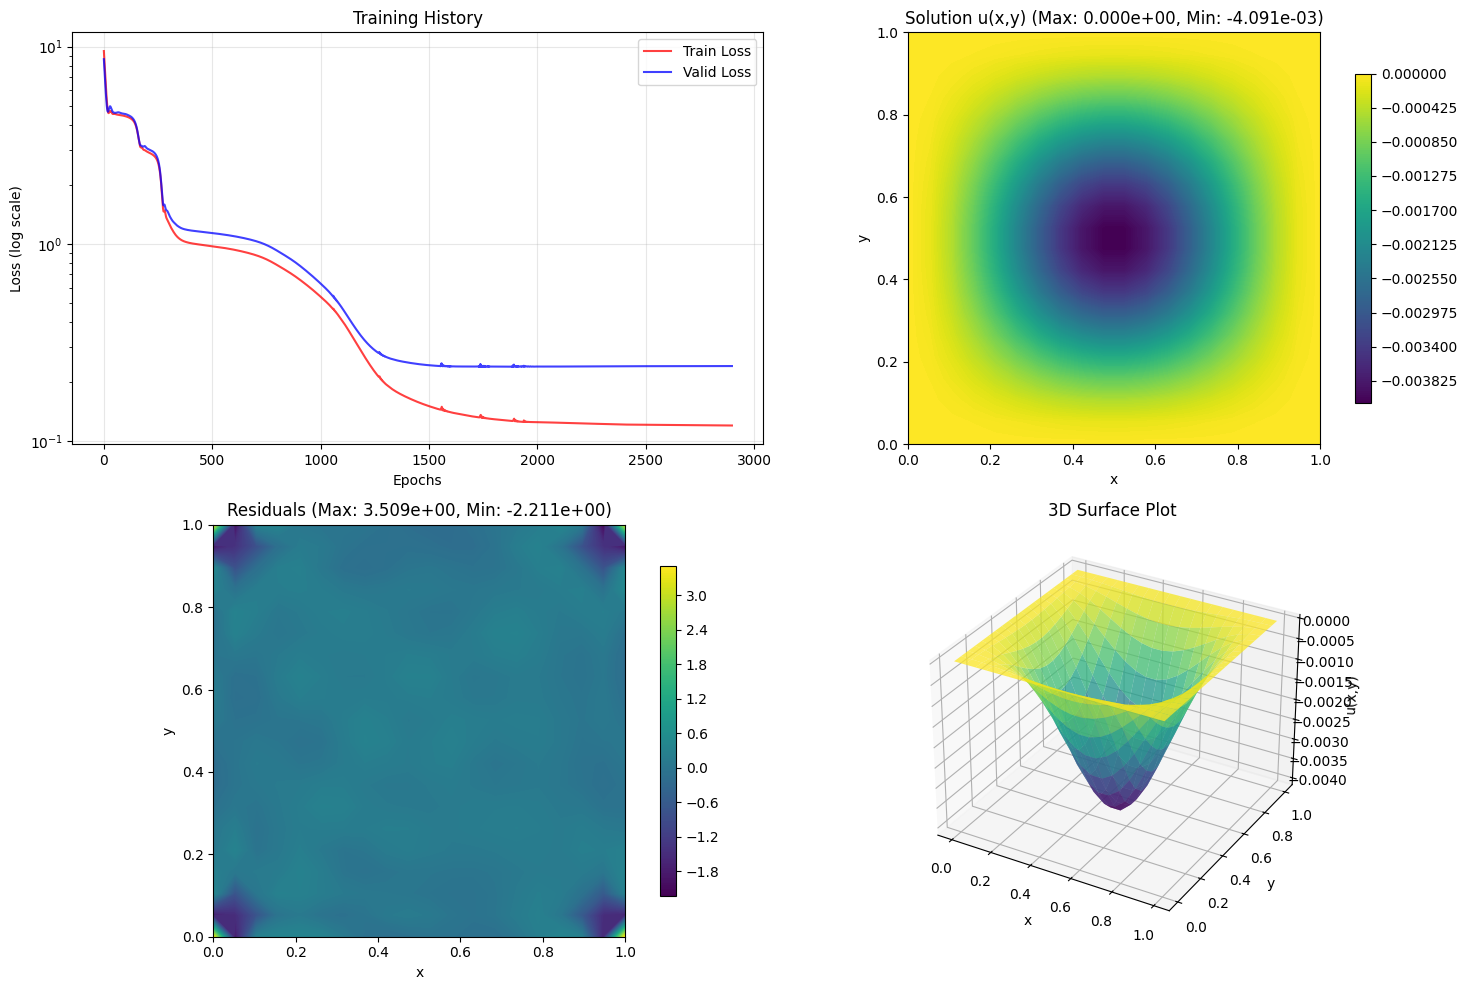

In [4]:
# Get losses
train_loss, valid_loss = sol.metrics_history["train_loss"], sol.metrics_history["valid_loss"]

# Get data
x_test, y_test = valid_generator.get_examples()
solution_nn = sol.get_solution()(x_test, y_test)
residuals = sol.get_residuals(x_test, y_test)

# Reshaping
x_test = x_test.detach().numpy().flatten().reshape(valid_generator.grid[0], valid_generator.grid[0])
y_test = y_test.detach().numpy().flatten().reshape(valid_generator.grid[0], valid_generator.grid[0])
solution_nn = solution_nn.detach().numpy().flatten().reshape(valid_generator.grid[0], valid_generator.grid[0])
residuals = residuals.detach().numpy().flatten().reshape(valid_generator.grid[0], valid_generator.grid[0])

# Create figure with 4 subplots
fig = plt.figure(figsize = (15, 10))

# Plot 1: Loss history
ax1 = plt.subplot(2, 2, 1)
ax1.plot(train_loss, 'r-', label = 'Train Loss', linewidth = 1.5, alpha = 0.75)
ax1.plot(valid_loss, 'b-', label = 'Valid Loss', linewidth = 1.5, alpha = 0.75)
ax1.set_yscale('log')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss (log scale)')
ax1.set_title('Training History')
ax1.legend()
ax1.grid(True, alpha = 0.3)

# Plot 2: Solution (contour plot)
ax2 = plt.subplot(2, 2, 2)
contour = ax2.contourf(x_test, y_test, solution_nn, levels = 200, cmap = 'viridis')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title(f'Solution u(x,y) (Max: {solution_nn.max():.3e}, Min: {solution_nn.min():.3e})')
plt.colorbar(contour, ax = ax2, shrink = 0.8)
ax2.set_aspect('equal')

# Plot 3: Residuals (contour plot)
ax3 = plt.subplot(2, 2, 3)
res_contour = ax3.contourf(x_test, y_test, residuals, levels = 200, cmap = 'viridis')
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_title(f'Residuals (Max: {residuals.max():.3e}, Min: {residuals.min():.3e})')
plt.colorbar(res_contour, ax = ax3, shrink = 0.8)
ax3.set_aspect('equal')

# Plot 4: 3D surface plot
ax4 = plt.subplot(2, 2, 4, projection = '3d')
surf = ax4.plot_surface(x_test, y_test, solution_nn, cmap = 'viridis', alpha = 0.75, linewidth = 0)
ax4.set_xlabel('x')
ax4.set_ylabel('y')
ax4.set_zlabel('u(x,y)')
ax4.set_title('3D Surface Plot')

plt.tight_layout()
plt.show()